In [1]:
!pip3 install sklearn progress iterative-stratification pandas pyss3


In [2]:
from sys import path
import os

# Standard Stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, hamming_loss,confusion_matrix, ConfusionMatrixDisplay, accuracy_score, multilabel_confusion_matrix, classification_report
# from util import binarize_to_list, binarize_to_matrix, predict_multilabel, eval_multilabel, load_multi_label, grid_search
import pyss3
from pyss3 import SS3, VERBOSITY
from pyss3.util import Dataset, Evaluation, span
from pyss3.server import Live_Test
from google.colab import drive

import numpy as np
import pandas as pd
import time
import itertools
import matplotlib.pyplot as plt


In [3]:
drive.mount('/content/drive', force_remount=True)
path_root = '/content/drive/My Drive/NLP Lab'
path.append(path_root)
data_root = '/data/Muneeb'
# single_label_dir = '/SB1_Train-entity'

Mounted at /content/drive


In [4]:
from util import binarize_to_list, binarize_to_matrix, predict_multilabel, eval_multilabel, load_multi_label, grid_search
multi_label_dir_train = '/Movie-Train'
multi_label_dir_test = '/Movie-Test'

In [5]:
multi_text_train, multi_labels_train = Dataset.load_from_files_multilabel(path_root + data_root + multi_label_dir_train + '/summaries.txt',path_root + data_root + multi_label_dir_train + '/genres.txt', sep_label=';')
multi_text_test, multi_labels_test = Dataset.load_from_files_multilabel(path_root + data_root + multi_label_dir_test + '/summaries.txt',path_root + data_root + multi_label_dir_test + '/genres.txt', sep_label=';')

100%|██████████| 5680/5680 [00:00<00:00, 521659.04it/s]


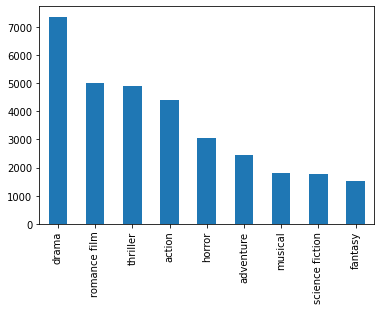

In [6]:
# CLASSES DISTRUBUTION

pd.Series([y for yy in multi_labels_train for y in yy]).value_counts().plot(kind ='bar')

In [7]:
def binarize_categories(cat, multi_labels_train):
  labels = []
  for i, x in enumerate(multi_labels_train):
    try:
      x.index(cat)
      if len(x) == 1:
        labels.append([cat])
      else:
        labels.append([cat, 'others'])
    except ValueError as e:
      labels.append(['others'])
  return labels

def predict(category_classifier,s_val,l_val,p_val,a_val, multi_text_test=multi_text_test):
    result = {}

    for key, value in category_classifier.items():
        value.set_hyperparameters(s=s_val,l=l_val,p=p_val)
        result[key]= value.predict(multi_text_test, def_cat='most-probable') 

    y_pred = [[] for _ in range(len(multi_text_test))]
    for i in range(len(multi_text_test)):
        temp = []
        for key, value in result.items():
            if value[i]:
                if value[i][0] != 'others':
                    temp.append(value[i][0])
            else:
                temp.append(key)
        y_pred[i] = list(set(temp))
    return y_pred


In [ ]:
### one vs rest classifier training ###
pyss3.set_verbosity(1)

categories = list(set([y for yy in multi_labels_train for y in yy]))
category_classifier = {}
for cat in categories:
  modified_labels = binarize_categories(cat, multi_labels_train)
  clf = SS3(name=cat)
  clf.train(multi_text_train, modified_labels)
  category_classifier[cat] = clf

### default classifier training ###
clf = SS3()
clf.train(multi_text_train, multi_labels_train, n_grams=5)

In [10]:
s=span(0, 1, 11)  # [0.2 , 0.32, 0.44, 0.56, 0.68, 0.8]
l=span(0, 1, 11)   # [0.1 , 0.48, 0.86, 1.24, 1.62, 2]
p=span(0, 1, 11)   # [1.75, 1.95, 2.15, 2.35, 2.55, 2.75]
a=span(0, 5, 6)

In [11]:
pyss3.set_verbosity(0)
slpa = list(itertools.product(s,l,p,a))
iterations = len(slpa)
divider = 50
current_iteration = 0
last_metric_value = 0
last_metric_value_default = 0
best_binarized_predicted = []
best_binarized_predicted_default = []
binarized_true = binarize_to_matrix(multi_labels_test, categories)


for s,l,p,a in iter(slpa):
    current_iteration += 1
    print('\r',current_iteration, end='')

    y_pred = predict(category_classifier,s,l,p,a)
    binarized_predicted = binarize_to_matrix(y_pred, categories)
    metric_value= eval_multilabel(binarized_true, binarized_predicted, f1_score, **{"average":"macro", "zero_division" : 0})
    ##save and print##
    if(metric_value > last_metric_value):
        best_binarized_predicted = binarized_predicted
        last_metric_value = metric_value
        best = (s,l,p,a)

    clf.set_hyperparameters(s,l,p,a)
    y_pred_default = clf.predict(multi_text_test)
    binarized_predicted_default = binarize_to_matrix(y_pred_default, categories)
    metric_value_default= eval_multilabel(binarized_true, binarized_predicted_default, f1_score, **{"average":"macro", "zero_division" : 0})
    if(metric_value_default > last_metric_value_default):
        best_binarized_predicted = binarized_predicted_default
        last_metric_value_default = metric_value_default
        best_default = (s,l,p,a)


    if(current_iteration%divider == 0):
        print(' -> best value so far: ', last_metric_value, ' -> best values: s={}, l={}, p={}, a={}'.format(best[0], best[1], best[2], best[3]), "iterations: ", current_iteration, "/", iterations)
        print(' -> best value so far: ', last_metric_value_default, ' -> best values: s={}, l={}, p={}, a={}'.format(best_default[0], best_default[1], best_default[2], best_default[3]), "iterations: ", current_iteration, "/", iterations)
        print('------------')

 1

In [ ]:
cms = multilabel_confusion_matrix(binarized_true, best_binarized_predicted)
print(classification_report(binarized_true, best_binarized_predicted,target_names=categories, zero_division=1))
Evaluation.__plot_confusion_matrices__(cms, categories, multilabel = True)

 10

**DEFAULT MULTI-LABEL**

In [ ]:
clf.set_hyperparameters(s=best_default[0], l=best_default[1], p=best_default[2], a=best_default[3])
Evaluation.test(clf, multi_text_test, multi_labels_test)